In [272]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import toeplitz

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

In [356]:
### network parameters
nn = 50  #number of neurons
N = 20  #number of patterns
taus = 10  #short time scale (in ms)
tauD = 100  #longer time scale
kappaD = int(tauD/taus)  #time delay in energy function
beta = 1  #slope in the nonlinearity

def spins(n):
    """
    make +/-1 spins
    """
    return 2*np.random.randint(0,2,n)-1

def NL(x,beta):
    """
    threshold nonlinearity with gain beta
    """
    V = np.zeros(len(x))
    for i in range(0,len(x)):
        if x[i]>=1/beta:
            V[i] = 1
        elif x[i]<1/beta and x[i]>-1/beta:
            V[i] = beta*x[i]
        elif x[i]<=-1/beta:
            V[i] = -1
    return V

def D_conv(V,D):
    nn = V.shape[0]
    Vd = np.zeros(nn)
    for ni in range(0,nn):
        Vd[ni] = np.dot(V[ni,:],D)  #neuron-wise convolution
    return Vd

In [413]:
### make patterns
# orthogonal patterns
# pp = 0.5
# M = np.eye(nn)  #np.cov(np.random.randn(nn,50)) #np.array([spins(nn) for i in range(0,N)])  #patterns by neurons
# R = np.random.rand(nn,nn)  #noise?
# R[R>pp] = 1
# R[R<=pp] = -1
# M = M+R
# np.fill_diagonal(M,np.ones(nn))
# M[M<1] = -1
# M = M[:N,:]

# random
M = np.array([spins(nn) for i in range(0,N)])  #patterns by neurons

# Toeplitz
# temp = np.concatenate((np.ones(3),np.zeros(nn-3)))
# M = toeplitz(temp)
# M[M<1] = -1
# M = M[:N,:]

### store patterns
#attractor states
T = np.zeros((nn,nn))
for ni in range(N):
    T = T + np.outer(M[ni,:],M[ni,:])
T = T/N
np.fill_diagonal(T,np.zeros(nn))

#transition states
D = np.zeros((nn,nn))
for ni in range(N-1):
    D = D + np.outer(M[ni+1,:],M[ni,:])
D = D/N
np.fill_diagonal(D,np.zeros(nn))

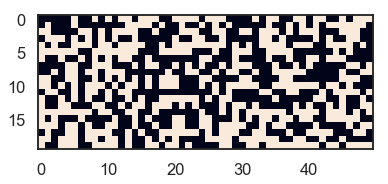

In [414]:
plt.imshow(M)

In [415]:
### neural dynamics
#time vector
dt = 0.1
TT = 1000
time = np.arange(0,TT,dt)

us = np.zeros((nn,len(time)))  #neural activity
us[:,0] = np.random.randn(nn)
Vd = np.zeros((nn,len(time)))  #delayed output state
Vtemp = np.zeros((nn,len(time)))  #template to convolute for output state
kappaD = 10
t_kernel = np.arange(0,dt*kappaD,dt)
D_kernel = np.exp(-t_kernel/tauD)/tauD  #kernel for delated output state
D_kernel = np.exp(-t_kernel/.1)/.1

for tt in range(0,len(time)-1):
    if tt>kappaD:
        Vtemp[:,tt] = NL(us[:,tt],beta)
        Vd[:,tt] = D_conv(Vtemp[:,tt-kappaD:tt], D_kernel)
    us[:,tt+1] = us[:,tt] + dt*(1/taus)*( -us[:,tt] + np.matmul(T,NL(us[:,tt],beta)) + np.matmul(D, Vd[:,tt] ))

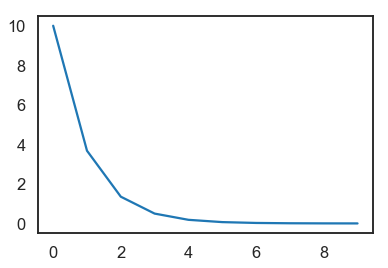

In [416]:
plt.plot(D_kernel)

Text(0, 0.5, 'activity')

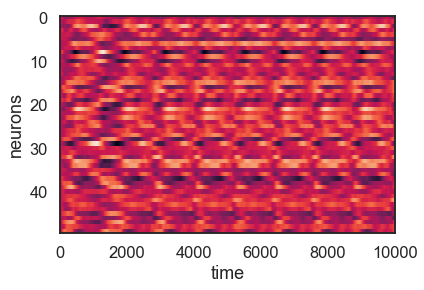

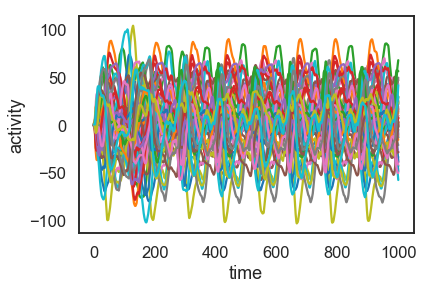

In [417]:
plt.imshow(us,aspect='auto')
plt.xlabel('time')
plt.ylabel('neurons')
plt.figure()
plt.plot(time,us.T);
plt.xlabel('time')
plt.ylabel('activity')

Text(0, 0.5, 'sorted neurons')

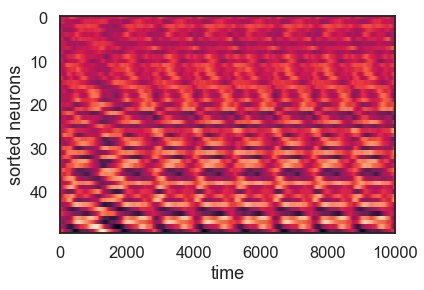

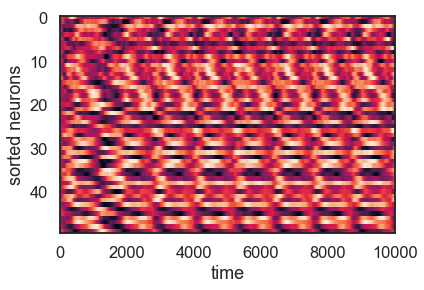

In [419]:
### sort sequence
def sort_sequence(heat):
    maxp = np.argmax(np.abs(heat),axis=1)
    maxs = np.max(np.abs(heat),axis=1)
    poss = np.argsort(maxs)
    sorted_heat = heat[poss,:]
    norm_sort = np.array([sorted_heat[ii]/max(np.abs(sorted_heat[ii])) for ii in range(0,heat.shape[0])])
    return sorted_heat, norm_sort

sort_, norm_ = sort_sequence(us)
plt.imshow(sort_,aspect='auto')
plt.xlabel('time')
plt.ylabel('sorted neurons')
plt.figure()
plt.imshow(norm_,aspect='auto')
plt.xlabel('time')
plt.ylabel('sorted neurons')

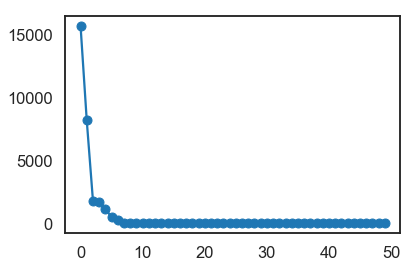

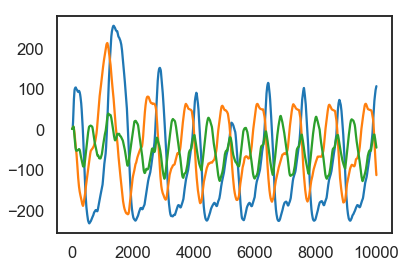

In [423]:
### linear dimensionality
uu,ss,vv = np.linalg.svd(np.cov(us))
plt.plot(ss,'-o')
plt.figure()
plt.plot((uu[:,:3].T @ us).T)